Transient Heat Transfer 1D
================

Let's get the process ID so that we can attach a debug later.

In [1]:
import os
print(os.getpid())

11132


In [2]:
# First you need to call
!python setup.py build_ext --inplace

running build_ext
running build_src
build_src
building extension "HeatTransfer1D" sources
build_src: building npy-pkg config files
No module named 'numpy.distutils._msvccompiler' in numpy.distutils; trying from distutils
customize MSVCCompiler
customize MSVCCompiler using build_ext


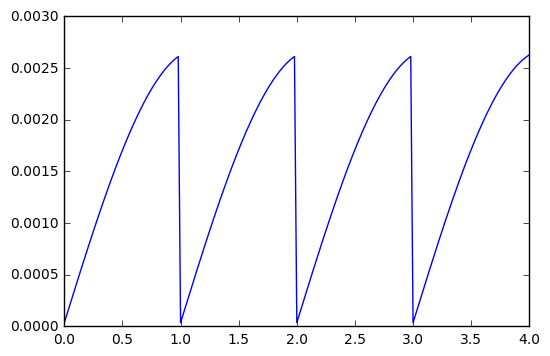

In [10]:
import sys
import numpy as np
import petsc4py
from petsc4py import PETSc
from matplotlib import pyplot as plt
import HeatTransfer1D



petsc4py.init(sys.argv)


class Heat(object):
    def __init__(self, dm, temperature_presc, conductivity, source_term, wall_length):

        self.dm = dm 
        self.k  = conductivity
        self.Q  = source_term
        self.L  = wall_length
        self.Tpresc = temperature_presc

    def evalFunction(self, ts, t, x, xdot, f):
        dm = self.dm
        Tpresc = self.Tpresc
        k  = self.k
        Q  = self.Q 
        L  = self.L

        with dm.getAccess(x, locs=None) as Xs:
            with dm.getAccess(xdot, locs=None) as X_ts:
                with dm.getAccess(f, locs=None) as Fs:
                    dx_avg = 0.0
                    size = len(Fs)
                    Fs[size-1][0] = 0.0
                    
                    for X, X_t, F, T in zip(Xs[:-1], X_ts[:-1], Fs[:-1], Tpresc):   
                        udot = X_t
                        u = X            
                        
                        dx = L / F.size
                        ff = np.zeros(F.size)
                        ff[1:-1] = udot[1:-1]*dx - Q*dx + k * (u[1:-1] -  u[:-2])/dx - k * (u[2:] - u[1:-1])/dx
                        
                        ff[ 0] = udot[       0]*dx - Q*dx - k * (u[       1] - u[       0])/dx
                        ff[-1] = udot[u.size-1]*dx - Q*dx + k * (u[u.size-1] - u[u.size-2])/dx
                        
                        # Internal Node
                        flux_term = k * (Xs[size-1][0] - u[u.size-1]) / dx
                        Fs[size-1][0] += +flux_term
                        ff[-1]  += -flux_term
                        
                        # BC's
                        ff[0] += +k * (u[0] - T) / (0.5*dx)
                        
                        F.setArray(ff)
                        dx_avg += dx
                    dx_avg /= len(Xs[:-1])
                    
                    Fs[size-1][0] += udot[size-1]*dx_avg - Q*dx_avg


def transient_heat_transfer_1D(
    npipes, nx, 
    initial_temperature,
    temperature_presc, 
    conductivity,
    source_term,
    wall_length,
    final_time,
    initial_time_step,
    impl_python=False
    ):
    
    # Time Stepper (TS) for ODE and DAE
    # DAE - https://en.wikipedia.org/wiki/Differential_algebraic_equation
    # https://www.mcs.anl.gov/petsc/petsc-current/docs/manualpages/TS/
    ts = PETSc.TS().create()

    # http://www.mcs.anl.gov/petsc/petsc-current/docs/manualpages/DM/index.html
    #
    pipes = []
    for i in range(npipes):
        pipes.append(PETSc.DMDA().create([nx],dof=1, stencil_width=1, stencil_type='star'))
    
    # Create a redundant DM, there is no petsc4py interface (yet)
    # so we created our own wrapper
    # http://www.mcs.anl.gov/petsc/petsc-current/docs/manualpages/DM/DMREDUNDANT.html
    dmredundant = PETSc.DM().create()
    dmredundant.setType(dmredundant.Type.REDUNDANT)
    HeatTransfer1D.redundantSetSize(dmredundant, 0, 1)
    dmredundant.setDimension(1)
    dmredundant.setUp()

    # http://www.mcs.anl.gov/petsc/petsc-current/docs/manualpages/DM/DMCOMPOSITE.html
    dm = PETSc.DMComposite().create()
    
    for pipe in pipes:        
        dm.addDM(pipe)

    dm.addDM(dmredundant)
    HeatTransfer1D.compositeSetCoupling(dm)
    
    ts.setDM(dm)

    F = dm.createGlobalVec()

    if impl_python:        
        ode = Heat(dm, temperature_presc, conductivity, source_term, wall_length)
        ts.setIFunction(ode.evalFunction, F)
    else:
        # http://www.mcs.anl.gov/petsc/petsc-current/docs/manualpages/TS/TSSetIFunction.html
        ts.setIFunction(HeatTransfer1D.formFunction, F,
                         args=(conductivity, source_term, wall_length, temperature_presc))    
    
    x = dm.createGlobalVec()
    
    x[...] = initial_temperature
    
    #HeatTransfer1D.formInitGuess(x, dm, initial_temperature)

    # http://www.mcs.anl.gov/petsc/petsc-current/docs/manualpages/TS/TSSetDuration.html
    ts.setDuration(max_time=final_time, max_steps=None)
    
    # http://www.mcs.anl.gov/petsc/petsc-current/docs/manualpages/TS/TSSetExactFinalTime.html
    ts.setExactFinalTime(ts.ExactFinalTimeOption.STEPOVER)
    
    # http://www.mcs.anl.gov/petsc/petsc-current/docs/manualpages/TS/TSSetInitialTimeStep.html
    ts.setInitialTimeStep(initial_time=0.0, initial_time_step=initial_time_step)
    
    # http://www.mcs.anl.gov/petsc/petsc-current/docs/manualpages/TS/TSSetProblemType.html
    ts.setProblemType(ts.ProblemType.NONLINEAR)
    
    # Another way to set the solve type is through PETSc.Options()
    #ts.setType(ts.Type.CRANK_NICOLSON)
    #ts.setType(ts.Type.THETA)
    #ts.setTheta(theta=0.9999)
    #ts.setType(ts.Type.EIMEX) # http://www.mcs.anl.gov/petsc/petsc-current/docs/manualpages/TS/TSEIMEX.html
    #ts.setType(ts.Type.BDF      )

    ts.setFromOptions()

    ts.solve(x)

    return x

options = PETSc.Options()
options.clear()

dt = 0.001                 # [s]
dt_min = 1e-4              # [s]
dt_max = 0.1               # [s]

#ts_type = "beuler"
#ts_type = "pseudo" # http://www.mcs.anl.gov/petsc/petsc-current/docs/manualpages/TS/TSPSEUDO.html
#ts_type = "cn"
ts_type = "bdf"
options.setValue('-ts_type', ts_type)

options.setValue('-ts_bdf_order', 3) # https://en.wikipedia.org/wiki/Backward_differentiation_formula
options.setValue('-ts_adapt_type', 'basic') # basic or none
options.setValue('-ts_bdf_adapt', '')
options.setValue('-ts_adapt_dt_min', dt_min)
options.setValue('-ts_adapt_dt_max', dt_max)
options.setValue('-ts_monitor', None)

dense = False
if dense:
    options.setValue('-dmcomposite_dense_jacobian', None)
else:
    options.delValue('-dmcomposite_dense_jacobian')

options.setValue('-ts_fd_color', None)

#options.setValue('-mat_view', 'draw')
#options.setValue('-draw_pause', 100)
#options.setValue('-is_coloring_view', '')
#options.setValue('-help', None)

npipes = 4
nx = 50
temperature_presc = np.array([2.0, 50.0, 55.0, 60.0]) # [degC]
initial_temperature = 10.0 # [degC]
conductivity = 1.0         # [W/(m.K)]
source_term = 00.0          # [W/m3]
wall_length = 1.0          # [m]

#time_intervals = [0.001, 0.01, 0.05, 0.1, 1.0]
time_intervals = [1.0]
sols = []
for final_time in time_intervals:
    sol = transient_heat_transfer_1D(
        npipes, nx, 
        initial_temperature,
        temperature_presc, 
        conductivity,
        source_term,
        wall_length,
        final_time,
        dt,
        impl_python=True
        )
    sols.append(sol[...])
    
x = np.linspace(0, npipes*wall_length, npipes*nx + 1)
for sol in sols:
    plt.plot(x, sol)
plt.show()

In [19]:
nx = 5000

In [20]:
%%timeit
sol = transient_heat_transfer_1D(
        npipes, nx, 
        initial_temperature,
        temperature_presc, 
        conductivity,
        source_term,
        wall_length,
        final_time,
        dt,
        impl_python=True
        )

1 loop, best of 3: 6.35 s per loop


In [21]:
%%timeit
sol = transient_heat_transfer_1D(
        npipes, nx, 
        initial_temperature,
        temperature_presc, 
        conductivity,
        source_term,
        wall_length,
        final_time,
        dt,
        impl_python=False
        )

1 loop, best of 3: 2.48 s per loop
